> GPT from Scratch: Transformers and LLMs Project for MIT 6.390 (Fall 2024)


The code in this notebook uses material written by Andrej Karpathy
See https://github.com/karpathy/ng-video-lecture
and https://github.com/karpathy/minGPT


Modern large language models (LLMs) are built using transformers, a particular neural network architecture that can be trained in parallel on large amounts of input data, such as a corpus of all known writings of humankind. In this notebook I explore the basic components of a Generative Pre-trained Transformer (GPT), a well-known LLM that is a stack of transformer blocks, each of which is composed from a number of self-attention transformer heads. Given its profound abilities, the architecture is relatively straightforward and the code constructed is essentially equivalent to GPT-1 and GPT-2.

In [ ]:
# imports

import torch
import torch.nn as nn
import traceback
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

A typical large language model (LLM) is autoregressive: it generates new tokens based on previous ones, and newly generated tokens are employed to generate following ones.

With the "vanilla" self-attention mechanism, any input token can affect any output token; i.e., tokens that occur later in a sequence are able to impact the earlier tokens:

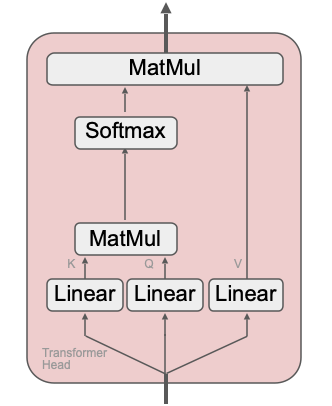

A sequence $ \{x^{(i)}\}_{j=1}^n $ of $ n $ tokens, each token $ x^{(i)} \in \mathbb{R}^{d \times 1} $, are the input to the head.

We learn three weight matrices: $ W_q, W_k, W_v $, all of which are in $ \mathbb{R}^{d \times d_k} $.

The matrix $ W_q $ transforms a token $ x^{(i)} $ into a question: which other tokens does $ x^{(i)} $ need to pay attention to? This question is represented as the query vector $ q_i = W_q^\top x^{(i)} $.

The matrix $ W_k $ transforms a token $ x^{(j)} $ into an answer to that question: if the query $ q_i $ is similar to the key $ k_j = W_k^\top x^{(j)} $, then $ q_i^\top k_j $ will be large, which means that $ x^{(i)} $ should pay attention to $ x^{(j)} $.

Thus, we compute the attention matrix as:

$$
A = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right) =
\begin{bmatrix}
\text{softmax}\left(\frac{q_1^\top k_1}{\sqrt{d_k}}, \frac{q_1^\top k_2}{\sqrt{d_k}}, \dots, \frac{q_1^\top k_n}{\sqrt{d_k}}\right) \\
\text{softmax}\left(\frac{q_2^\top k_1}{\sqrt{d_k}}, \frac{q_2^\top k_2}{\sqrt{d_k}}, \dots, \frac{q_2^\top k_n}{\sqrt{d_k}}\right) \\
\vdots \\
\text{softmax}\left(\frac{q_n^\top k_1}{\sqrt{d_k}}, \frac{q_n^\top k_2}{\sqrt{d_k}}, \dots, \frac{q_n^\top k_n}{\sqrt{d_k}}\right)
\end{bmatrix}
$$

Now, we know which tokens are most relevant to other tokens! But how can we use that? The matrix $ W_v $ transforms every token $ x^{(j)} $ into a value $ v^{(j)} $, which we can put all together to get a matrix $ V $. The attention matrix is then multiplied by this matrix of values to get an output. In particular, the $ i $-th output is given by:

$$
\text{out}^{(i)} = \sum_{j=1}^n A_{i,j} v^{(j)}.
$$




To achieve the autoregressive nature of an LLM, we use **masking**. Suppose we train a transformer to predict the next word in the sequence: "quantum computers will work someday." Each word $x^{(i)}$ in the input corresponds to a token, and the target output $y^{(i)}$ is the same sequence, shifted one position left, ending with an EOS token:

$x^{(1)}$: quantum, $x^{(2)}$: computers, $x^{(3)}$: will, $x^{(4)}$: work, $x^{(5)}$: someday  
$y^{(1)}$: computers, $y^{(2)}$: will, $y^{(3)}$: work, $y^{(4)}$: someday, $y^{(5)}$: EOS

Autoregression ensures the model generates $y^{(t)}$ based only on $x^{(1)}, x^{(2)}, \dots, x^{(t)}$, not future tokens. We enforce this by **masking** the attention matrix to ignore "future" tokens. The desired lower triangular attention matrix looks like:

$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0.5 & 0.5 & 0 & 0 & 0 \\
0.3 & 0.3 & 0.4 & 0 & 0 \\
0.4 & 0.1 & 0.2 & 0.3 & 0 \\
0.1 & 0.2 & 0.1 & 0.3 & 0.3
\end{bmatrix}
$

This ensures that each output word is influenced only by itself and preceding input words. Masking is applied during training to maintain sequential order and prevent "look-ahead" behavior.

# Masked fill

Filling certain elements of a matrix can be done efficiently. In pytorch, the masked_fill procedure allows us to set desired elements of a tensor to a specified value.

In [ ]:
a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]], dtype=float)
mask = torch.tril(torch.ones(3,3))
a.masked_fill(mask==0, -float("inf"))

tensor([[1., -inf, -inf],
        [4., 5., -inf],
        [7., 8., 9.]], dtype=torch.float64)

# Self-attention implemented in pytorch

Masked self-attention can therefore be implemented in pytorch as such:

In [ ]:
# This is a simplified demonstration of self-attention in pytorch
class masked_self_attention:
    def __init__(self, n=3, d=4):
        self.n = n
        self.d = d

    def self_attention(self, x, d_k=5):
        '''
        single self-attention head
        x has shape (n, d)
        d_k is the dim of qvk embedding
        '''
        d = self.d
        n = self.n
        Wk = torch.nn.Linear(d, d_k, bias=False)    # input_size, output_size
        Wq = torch.nn.Linear(d, d_k, bias=False)
        Wv = torch.nn.Linear(d, d_k, bias=False)
        k = Wk(x)
        q = Wq(x)
        M = torch.tril(torch.ones(n, n))            # lower triangle mask
        alpha = q @ k.transpose(-2,-1) * d_k**-0.5
        alpha = alpha.masked_fill(M == 0, float('-inf'))
        alpha = torch.softmax(alpha, dim=-1)
        plt.matshow(alpha.detach())                 # plot attention weight matrix
        plt.colorbar()
        v = Wv(x)
        out = alpha @ v
        return out


output has shape  torch.Size([3, 5])


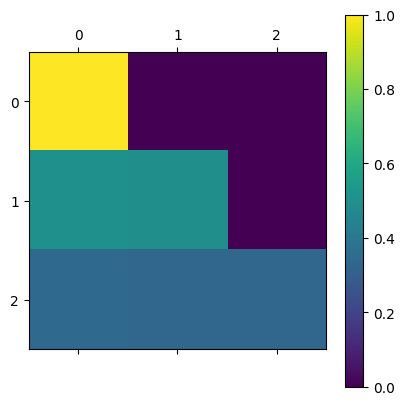

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize masked_self_attention with n=3 (sequence length) and d=4 (feature dimension)
msa = masked_self_attention(n=3, d=4)

# Define x as a tensor of shape (n, d)
# This is an example tensor with arbitrary values
x = torch.tensor([[1.0, 0.5, 0.2, 0.1],
                  [0.0, 0.3, 0.8, 0.4],
                  [0.5, 0.2, 0.1, 0.7]], dtype=torch.float32)

# Run self-attention with d_k=5
g = msa.self_attention(x, d_k=5)

# Print the output shape
print("output has shape ", g.shape)


## Hyperparameters

In [ ]:
#-----------------------------------------------------------------------------
# hyperparameters

batch_size = 16
block_size = 32
max_iters = 3000
eval_interval = 300
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 1
if 0:
    # large model
    d = 64
    n_head = 4
    n_layer = 4
else:
    # small model
    d = 24
    n_head = 3
    n_layer = 2

torch.manual_seed(1337)         # set random number generator seed for easier debugging

## Transformer Block

A transformer block is shown below. There are typically $H$ self-attention heads (shown as the red boxes in the diagram below). Importantly, each head $h$ has its own specific attention matrix and processes the input sequence in parallel.

The transformer block adds three additional new constructs to the network: (1) layer normalization blocks, (2) residual connections, and (3) a feed-forward block:

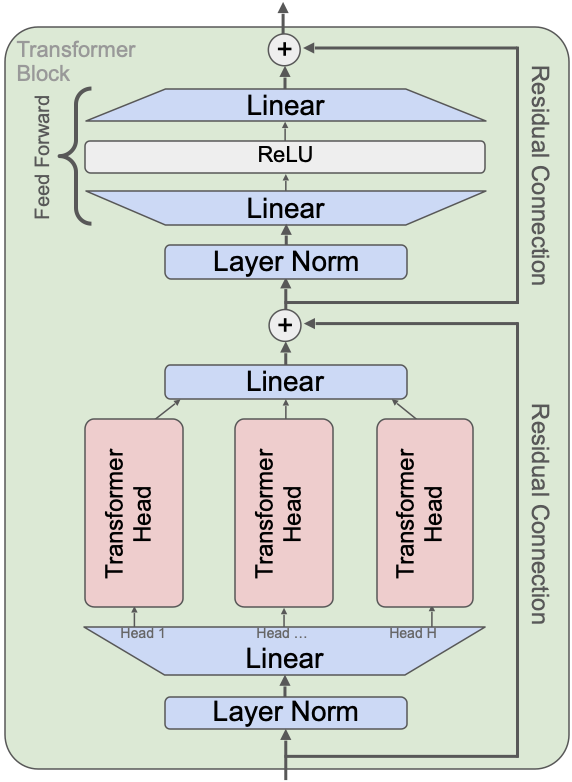


### LayerNorm

LayerNorm transforms an input $z$ into  
$ \text{LayerNorm}(z; \gamma, \beta) = \gamma \frac{z - \mu}{\sigma} + \beta $  
with learned parameters $\gamma$ and $\beta$.

The purpose of LayerNorm is to standardize its input so that the next layer's inputs are within a normal range, improving stability during training. In transformers, LayerNorm is used twice: at the input to the block and before the feed-forward layers. In PyTorch, we implemented this via `torch.nn.LayerNorm`.

If `torch.nn.LayerNorm(5)` is used, the total number of learned parameters is $2 \times 5 = 10$, corresponding to the dimensions of $\gamma$ and $\beta$.

---

### Residual connections

Residual connections are employed twice in the transformer block:  
1. Around the multi-headed attention module.  
2. Around the feed-forward layers.

The purpose of residual connections is to enable gradients to backpropagate more effectively through multiple stages of the network. They prevent vanishing gradients by ensuring a direct pathway for gradient flow, even if activation functions like ReLU return zeros.

---

### Feed-forward

The feed-forward stage in a transformer block is a non-linear activation (typically ReLU) sandwiched between two linear layers.

The linear layers map data from $d$ dimensions to a larger dimension, e.g., $4d$, and back to $d$.

---

### Transformer block
Putting the above pieces together, the transformer block can then be implemented in pytorch.

## GPT Architecture

GPT has $L$ sequentially stacked transformer blocks. On the input's end, we notice a positional encoding (to be described later). A normalization and softmax is used to output a next-character probability distribution.

### Positional encoding

The order of words in a sentence is crucial for meaning. For example, "The cat chased the mouse." and "The mouse chased the cat." convey entirely different meanings.

Since transformers process all input tokens in parallel, we can enable them to capture positional meaning by adding positional information to the input tokens.

The simplest approach embeds the input token $x^{(i)}$ as the vector $(W_x)^\top x^{(i)}$, and does the same for the position index $i$, turning it into the vector $(W_p)^\top e_i$, where $e_i$ is a one-hot vector with a $1$ in dimension $i$. The new input $x^{(i)}$ with positional encoding becomes:

$x^{(i)} = (W_x)^\top x^{(i)} + (W_p)^\top e_i$

Here, $W_x$ and $W_p$ are weight matrices learned through backpropagation. While this approach suffices for many cases, positional encoding is often implemented more sophisticatedly in practice.


In [ ]:
#-----------------------------------------------------------------------------
# The GPT model, in five pieces:
#
# 1. Single self-attention head
# 2. Multi-headed attention
# 3. Feed-forward = simple linear layer with ReLU nonlinearity
# 4. Transformer block = Multi-headed attention + Feed-forward + layer norms
# 5. Full GPT model = embedding + L transformer blocks + final layer norm

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, d_k):
        super().__init__()
        self.Wk = nn.Linear(d, d_k, bias=False)
        self.Wq = nn.Linear(d, d_k, bias=False)
        self.Wv = nn.Linear(d, d_k, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # input of size (batch, n/time-step, d or input embedding/channel)
        # output of size (batch, time-step, qvk embedding)
        B,T,C = x.shape
        k = self.Wk(x)   # (B,T,hs)
        q = self.Wq(x)   # (B,T,hs)
        # compute attention weights
        alpha = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        alpha = alpha.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        alpha = F.softmax(alpha, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.Wv(x) # (B,T,hs)
        out = alpha @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, d_k):
        super().__init__()
        self.heads = nn.ModuleList([Head(d_k) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, n_head):
        # d: input embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        # the line below means d_k * H = d, this is just done out of convenience
        d_k = d // n_head
        self.sa = MultiHeadAttention(n_head, d_k)
        self.ffwd = FeedFoward(d)
        self.ln1 = nn.LayerNorm(d)
        self.ln2 = nn.LayerNorm(d)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, d)
        self.position_embedding_table = nn.Embedding(block_size, d)
        self.blocks = nn.Sequential(*[Block(d, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(d) # final layer norm
        self.lm_head = nn.Linear(d, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1) 	# "ignore_index=-1" causes y = -1 labeled data to be ignored

        return logits, loss

    def generate(self, idx, max_new_tokens, do_sample=False):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # either sample from the distribution or take the most likely element
            if do_sample:
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


## Training dataset and loss estimation

In [ ]:
#-----------------------------------------------------------------------------
# Training dataset setup
# data encoder, decoder, dataset generator for addition problem

ndigit = 3
vocab_size = 10         # vocab is the digits 0-9

def num2input(num, the_ndigit=ndigit):
    '''
    Encode number as ndigit integers
    '''
    nmax = 10**the_ndigit
    if num >= nmax:
        raise Exception(f"oops, number {num} must be less than {nmax}")
    render = f"%0{the_ndigit}d" % num
    dix = [int(s) for s in render] # convert each character to its token index
    return dix

def output2num(outlist):
    '''
    Decode output list to produce predicted sum
    '''
    assert len(outlist)==3*ndigit + 1
    sumdigits = outlist[-(ndigit+1):][::-1]     # take last ndigit+1 digits, and reverse order
    sumstr = ''.join([str(x) for x in sumdigits])
    sumnum = int(sumstr)
    return sumnum

class AdditionDataset(Dataset):
    """
    Creates n-digit addition problems. For example, if n=2, then an example
    addition problem would be to add 85 + 50 = 135. This problem would be
    represented as the following string for the GPT:

    "8550531"

    This is because:
    - we are discarding the + and =, which are not necessary. We just encode the digits
      of the input numbers concatenated together.
    - the result 135 is encoded backwards to make the addition easier to learn for the
      GPT model, because of how the addition algorithm works.

    As one more example, the problem 6 + 39 = 45 would be encoded as:

    "0639054"

    where you will notice that we are padding with zeros to make sure that we always
    produce strings of the exact same size: n + n + (n + 1). When n=2, this is 7.
    At test time, we will feed in an addition problem by giving the first 2n digits,
    and hoping that the GPT model completes the sequence with the next (n+1) digits
    correctly.
    """

    @staticmethod
    def get_default_config():
        C = CN()
        # C.ndigit = 2
        C.ndigit = 3
        return C

    def __init__(self, split):
        self.split = split # train/test

        # split up all addition problems into either training data or test data
        assert ndigit <= 3, "the lines below would be very memory inefficient, in future maybe refactor to support"
        num = (10**ndigit)**2 # total number of possible addition problems with ndigit numbers
        if split=="train":
            print("number of possible addition problems: %.2fM" % (num/1e6,))
        rng = torch.Generator()
        rng.manual_seed(1337)
        perm = torch.randperm(num, generator=rng)
        num_test = min(int(num*0.2), 500) # 20% of the whole dataset, or only up to 500
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def get_vocab_size(self):
        return 10 # digits 0..9

    def get_block_size(self):
        # a,b,a+b, and +1 due to potential carry overflow,
        # but then also -1 because very last digit doesn't ever plug back
        # as there is no explicit <EOS> token to predict, it is implied
        return 3*ndigit + 1 - 1

    def __len__(self):
        return self.ixes.nelement()

    def __getitem__(self, idx):
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx].item()
        nd = 10**ndigit
        a = idx // nd
        b = idx %  nd
        # calculate the "label" of the addition problem a + b
        c = a + b
        # encode the digits of a, b, c into strings
        astr = f'%0{ndigit}d' % a
        bstr = f'%0{ndigit}d' % b
        cstr = (f'%0{ndigit+1}d' % c)[::-1] # reverse c to make addition easier
        render = astr + bstr + cstr
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:ndigit*2-1] = -1 # we will only train in the output locations. -1 will mask loss to zero
        return x, y


In [ ]:
#-----------------------------------------------------------------------------
# setup datasets and provide procedure to estimate loss

train_dataset = AdditionDataset(split='train')
test_dataset  = AdditionDataset(split='test')

loader = {}
data_iter = {}
for split in ['train', 'test']:
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    loader[split] = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    data_iter[split] = iter(loader[split])

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    try:
        batch = next(data_iter[split])
    except StopIteration:
        data_iter[split] = iter(loader[split])
        batch = next(data_iter[split])
    batch = [t.to(device) for t in batch]
    x, y = batch
    return x, y

@torch.no_grad()
def estimate_loss():
    '''
    Compute estimate of loss function and current performance of GPT.
    This is run periodically during training.
    '''
    out = {}
    model.eval()
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(device)
        results = []
        mistakes_printed_already = 0
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()

            if split=='train':
                continue
            X = X.to(device)
            d1d2 = X[:, :ndigit*2]
            d1d2d3 = model.generate(d1d2, ndigit+1, do_sample=False) # using greedy argmax, not sampling
            # isolate the last digit of the sampled sequence
            d3 = d1d2d3[:, -(ndigit+1):]
            d3 = d3.flip(1) # reverse the digits to their "normal" order
            # decode the integers from individual digits
            d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
            d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
            d3i_pred = (d3 * factors).sum(1)
            d3i_gt = d1i + d2i # manually calculate the ground truth
            # evaluate the correctness of the results in this batch
            correct = (d3i_pred == d3i_gt).cpu()
            for i in range(X.size(0)):
                results.append(int(correct[i]))
                if not correct[i] and mistakes_printed_already < 5: # only print up to 5 mistakes to get a sense
                    mistakes_printed_already += 1
                    print("    GPT claims that %d + %d = %d but should be %d" % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i]))
        if split=='test':
            rt = torch.tensor(results, dtype=torch.float)
            print("    %s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))

        out[split] = losses.mean()

    # revert model to training mode
    model.train()
    return out

number of possible addition problems: 1.00M


## adderGPT performance

I now attempt to train a GPT model to learn addition from scratch (without explicit/traditional addition rules). The input consists of two three-digit decimal numbers, and the output is their four-digit sum. The model’s performance is explored as a function of transformer block layers $L$ and the number of heads $H$, with $d = 24$.

### Key Details:
- **Number of three-digit addition problems:** $10^3 \times 10^3 = 10^6$ (1 million problems).
- **Parameter counts:** With $L = 1$ and $H = 1$, the model has fewer parameters due to its simpler architecture. For $L = 2$ and $H = 3$, the parameter count increases with more layers and heads.

### Experimental Setup:
Addition problems like $385 + 51 = 436$ are represented as: 3850516340


#### Representation Details:
- The `+` and `=` are discarded; only digits are concatenated.
- The result ($436$) is encoded **in reverse order** (e.g., `634`) for easier learning, inspired by ripple-carry addition.
- **Vocabulary size:** 10 (digits 0–9).  
- **Input and output lengths:** Fixed, with zero-padding for smaller numbers and sums with fewer than four digits.

#### Input and Target Encoding:
For a problem $a + b = c$ (e.g., $a = a_2a_1a_0$), the training input $x$ and target $y$ are:

$x = a_2, a_1, a_0, b_2, b_1, b_0, c_0, c_1, c_2$  
$y = -1, -1, -1, -1, -1, -1, c_0, c_1, c_2$

Here, $y^{(t)} = -1$ masks irrelevant positions to focus on predicting $c$ correctly.

During testing, adderGPT then tokenizes the input and generates the sum one digit at a time in sequence.

In [ ]:
#-----------------------------------------------------------------------------
# train model

n_head = 3
n_layer = 2

print(f"Training GPT with L={n_layer} and H={n_head}")

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for itern in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if (itern > 0) and (itern % eval_interval == 0 or itern == max_iters - 1):
        losses = estimate_loss()
        print(f"step {itern}: train loss {losses['train']:.4f}, test loss {losses['test']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Training GPT with L=2 and H=3
0.01441 M parameters
    GPT claims that 387 + 415 = 1111 but should be 802
    GPT claims that 459 + 365 = 1111 but should be 824
    GPT claims that 543 + 856 = 1131 but should be 1399
    GPT claims that 59 + 742 = 1111 but should be 801
    GPT claims that 549 + 75 = 1111 but should be 624
    test final score: 1/100 = 1.00% correct
step 300: train loss 1.8054, test loss 1.7996
    GPT claims that 813 + 804 = 1707 but should be 1617
    GPT claims that 985 + 799 = 1794 but should be 1784
    GPT claims that 216 + 847 = 1123 but should be 1063
    GPT claims that 577 + 473 = 1000 but should be 1050
    GPT claims that 842 + 735 = 1517 but should be 1577
    test final score: 7/100 = 7.00% correct
step 600: train loss 1.1725, test loss 1.2174
    test final score: 100/100 = 100.00% correct
step 900: train loss 0.2494, test loss 0.2610
    test final score: 100/100 = 100.00% correct
step 1200: train loss 0.0486, test loss 0.0479
    test final score: 100/

In [ ]:
#-----------------------------------------------------------------------------
# generate output from the model
# interactively accept input from user and print results from GPT
# Provide empty input to terminate

while True:
    args = input("Enter a, b: ").strip()
    if len(args)==0 or "quit" in args:
        break
    try:
        a, b = [int(x.strip()) for x in args.split(",")]
        abin = num2input(a) + num2input(b)
        context = torch.tensor([ abin ], dtype=torch.long, device=device)
        print(f"    abin={abin}, context={context}")
        ret = m.generate(context, max_new_tokens=(ndigit+1))[0].tolist()
        print(f"    GPT raw return = {ret}")
        sumnum = output2num(ret)
        if sumnum == a+b:
            comment = "Correct!"
        else:
            comment = "Wrong!"
        print(f"GPT says {a} + {b} = {sumnum}  --> {comment}")

    except Exception as err:
        print(traceback.format_exc())
        print(err)

KeyboardInterrupt: Interrupted by user

## Visualizing digit attention

Each transformer block has $H$ transformer heads, and each head $h$ learns its own set of weights $(W_q, W_k, W_v)$ for a given input. This means the attention matrices produced by each attention head are independent of one another.

It is insightful to examine the values of the attention matrix to determine which input tokens $j$ are being paid attention to for generating the output token $i$.

In [ ]:
# call model once to see how a single digit addition is done
# Ideally, GPT should output a + b

a, b = 3, 5    # modify this to explore different values for these single-digit inputs

context = torch.tensor([ num2input(a) + num2input(b)], dtype=torch.long)
logits, loss = m(context)
logits = logits[:, -1, :] # becomes (B, C)
probs = F.softmax(logits, dim=-1) # (B, C)
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
print(idx_next)   # this should be the least-significant digit of a + b

tensor([[8]])


iseq=[9, 2, 3, 0, 5, 7], res=[0, 8, 9, 0]
[9, 2, 3, 0, 5, 7]
alpha= [0.00013736862456426024, 0.0016717250691726804, 0.5122371912002563, 0.00018418066611047834, 0.0020840689539909363, 0.48368555307388306]
[9, 2, 3, 0, 5, 7, 0]
alpha= [0.003952596336603165, 0.4926985204219818, 0.009097832255065441, 0.002890070667490363, 0.465581476688385, 0.009197333827614784, 0.016582226380705833]
[9, 2, 3, 0, 5, 7, 0, 8]
alpha= [0.5006138682365417, 0.009346785955131054, 0.000563320005312562, 0.4701473116874695, 0.0077629294246435165, 0.0005701396730728447, 0.0032295899000018835, 0.0077660284005105495]
[9, 2, 3, 0, 5, 7, 0, 8, 9]
alpha= [0.47487565875053406, 0.039723146706819534, 0.000261949171544984, 0.36057788133621216, 0.03295101970434189, 0.000276383594609797, 0.0026795007288455963, 0.01651892624795437, 0.0721355676651001]


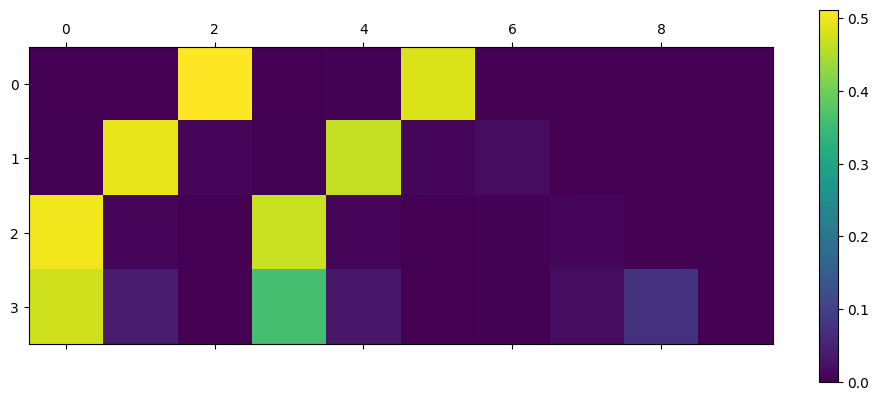

In [ ]:
# print this out as successive outputs are generated
ablock = m.blocks[0]            # this selects the transformer block
ahead = ablock.sa.heads[1]      # this selects the head within the block
a, b = 923, 57
iseq = num2input(a) + num2input(b)
res = num2input(a+b, ndigit+1)[::-1]
print(f"iseq={iseq}, res={res}")
amat = []
maxlen = 3*ndigit+1
for _ in range(4):
    print(iseq)
    context = torch.tensor([ iseq ], dtype=torch.long)
    B, T = context.shape
    tok_emb = m.token_embedding_table(context) # (B,T,C)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = ablock.ln1(tok_emb + pos_emb)
    # print("x=", x)
    # ahead(x)
    q = ahead.Wq(x)
    k = ahead.Wk(x)
    alpha = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
    alpha = alpha.masked_fill(ahead.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    alpha = F.softmax(alpha, dim=-1) # (B, T, T)
    alpha_last = alpha[-1,-1,:].tolist()
    print("alpha=", alpha_last)
    amat.append(alpha_last + [0]*(maxlen - len(alpha_last)))
    iseq.append(res[0])
    res = res[1:]
# make a nice plot
plt.matshow(torch.tensor(amat))
plt.colorbar()
plt.show()